In [1]:
# Работа с данными
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Построение моделей
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats 

# Вспомогательные библиотеки
from collections import Counter

In [2]:
# Считываем датасет
d = pd.read_csv("оценка_категорий.csv")
d.head(3)

,Date,CityName,OrderSource,Category,rto,rto_do,cost,tickets,qty,clients_qty,avg_time,avg_price
0,2022-01-01T00:00:00.000Z,Абакан,mp,пицца,83118.110,83162.76,19535.9630,61.0,152.0,123.0,24.278042,546.82965
1,2022-01-01T00:00:00.000Z,Абакан,mp,закуски,13115.895,12950.67,4141.1035,15.0,64.0,45.0,40.270145,204.93585
2,2022-01-01T00:00:00.000Z,Абакан,mp,напитки,1862.760,2533.80,854.5993,9.0,20.0,22.0,37.050053,93.13800


## Задание

Предположим в ряде городов в определенный период проведен тест:

В тестовых городах на веб-сайте пиццы располагаются по популярности

Во всех остальных по увеличению цены на пиццу


In [3]:
# Создаем тестовые города
test_cities = ["Пенза", "Уфа", "Курск", "Нижний Тагил", "Новокуйбышевск", "Орск"]

# Заодно создаем и контрольные города
controle_cities = [city for city in d.CityName.unique() if city not in test_cities+["Вышний Волочек', 'Копейск', 'Лабытнанги', 'Прокопьевск"]]


In [4]:
#Test dates 7 апреля - 19 мая

In [5]:
# Нас итересует только WEB
d.OrderSource.unique()

array(['mp', 'other', 'web'], dtype=object)

## 1 вопрос
### На какие метрики мог повлиять тест?

rto: выручка после скидок (по пицце)

tickets: кол-во заказов (под большим вопросов, но вдруг новый интерфейс мог "спугнуть" людей)

avg_time - ср время (вполне мб, дольше или быстрее ищут пиццу)

In [6]:
# Переводим дату в DateTime
d["Date"] = pd.to_datetime(d["Date"])

# выделю урезанный датасет в тестовый период
time_condition = (d["Date"] >= "2022-04-07") & (d["Date"] <= "2022-05-19")
source_condition = d["OrderSource"] == "web"

# Для упрощения пока рассмотрим только пиццы
category_condition = d["Category"] == "пицца"
city_condition = d["CityName"].isin(test_cities) 
time_before = (d["Date"] < "2022-04-07")


d = d[(time_condition | time_before) & source_condition & category_condition]

d["test"] = 1*(city_condition & time_condition)
d["time_before"] = 1*time_before

In [7]:
st = d[["Date", "CityName", "rto"]]
st_after = d[time_condition][["Date", "CityName", "rto"]]
st_before = d[d.time_before == 1][["Date", "CityName", "rto"]]

/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_5289/3734440408.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  st_after = d[time_condition][["Date", "CityName", "rto"]]


In [8]:
st = pd.pivot_table(st, values=['rto'], index= "Date",
                    columns=['CityName'])

### На первый взгляд кажется что в данных нет пропущенных значений, но первое впечатление обманчиво....

<Axes: >

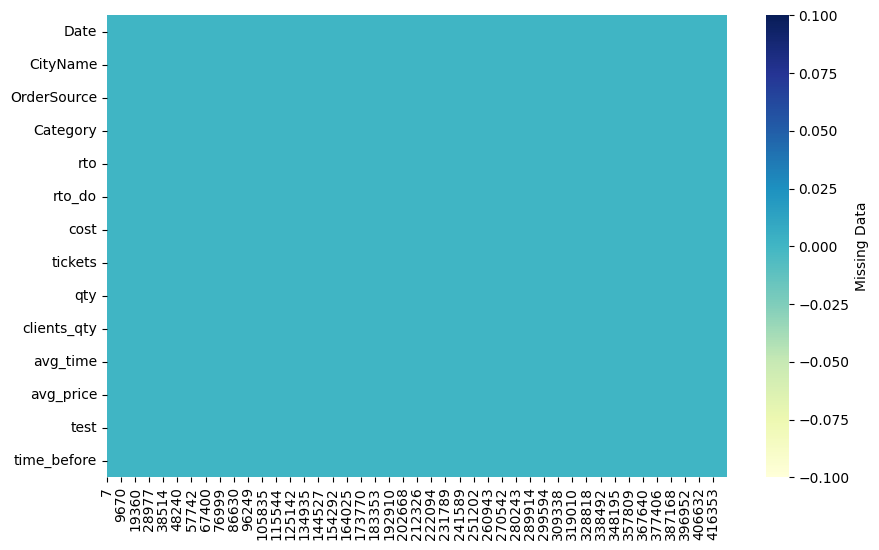

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(d.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

### Но если мы немного изменим структуру нашего датасета, то обнаружим пропущенные значения

<Axes: xlabel='Date', ylabel='None-CityName'>

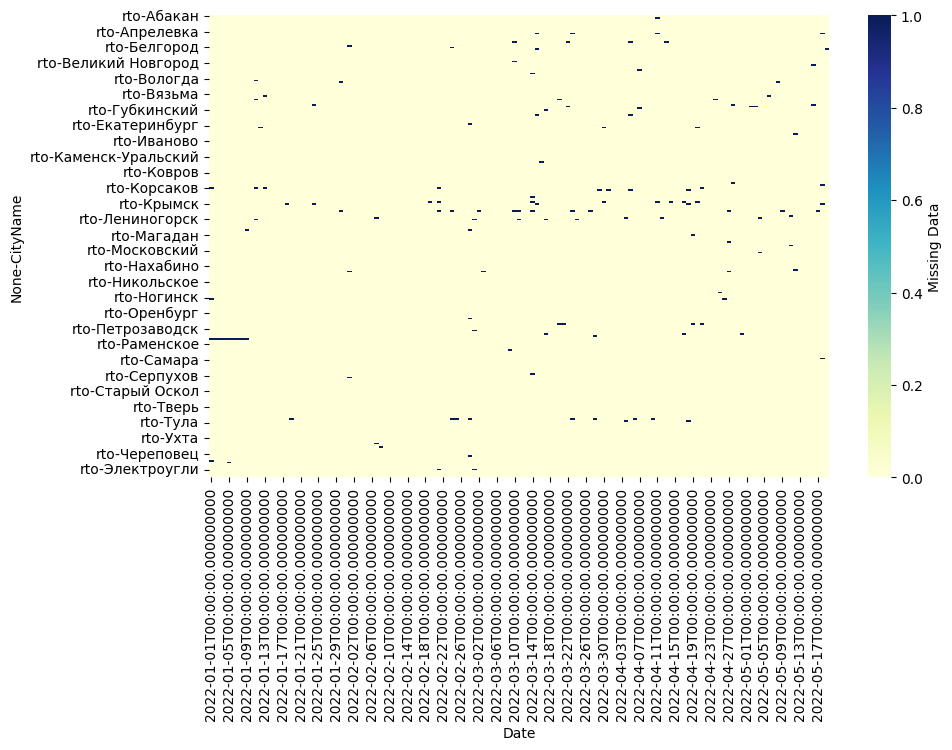

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(st.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [11]:
st.dropna(inplace = True)

In [12]:
# Условие для выделения тестовой выборки за тестовый период
city_condition = d["CityName"].isin(test_cities) 
d["test"] = 1*(city_condition & time_condition)
d[d["test"] == 1].head()

,Date,CityName,OrderSource,Category,rto,rto_do,cost,tickets,qty,clients_qty,avg_time,avg_price,test,time_before
294680,2022-04-07 00:00:00+00:00,Курск,web,пицца,11764.800,11484.51,2723.6220,15.0,19.0,22.0,21.188581,619.20000,1,0
295117,2022-04-07 00:00:00+00:00,Нижний Тагил,web,пицца,17898.027,19388.49,4850.6157,31.0,38.0,28.0,40.000000,471.00073,1,0
295153,2022-04-07 00:00:00+00:00,Новокуйбышевск,web,пицца,6119.760,6665.37,1604.2008,13.0,14.0,9.0,16.094730,437.12570,1,0
295358,2022-04-07 00:00:00+00:00,Орск,web,пицца,9108.690,8758.83,2499.1912,14.0,18.0,16.0,19.244793,506.03833,1,0
295394,2022-04-07 00:00:00+00:00,Пенза,web,пицца,63921.875,71117.37,16627.9120,74.0,128.0,83.0,17.345972,499.38965,1,0


In [13]:
d = d.sort_values(by = ["CityName", "Date"])
d_test = d[d["test"] == 1]
d_control = d[d["test"] == 0]

In [14]:
#Checking missing values

## 2

Сделай визуальный анализ датасета. 

Как ведут себя метрики в динамике? 

Какие распределения в данных?

# Динамика основных метрик

Text(0.5, 0.98, 'Динамика выручки до скидок')

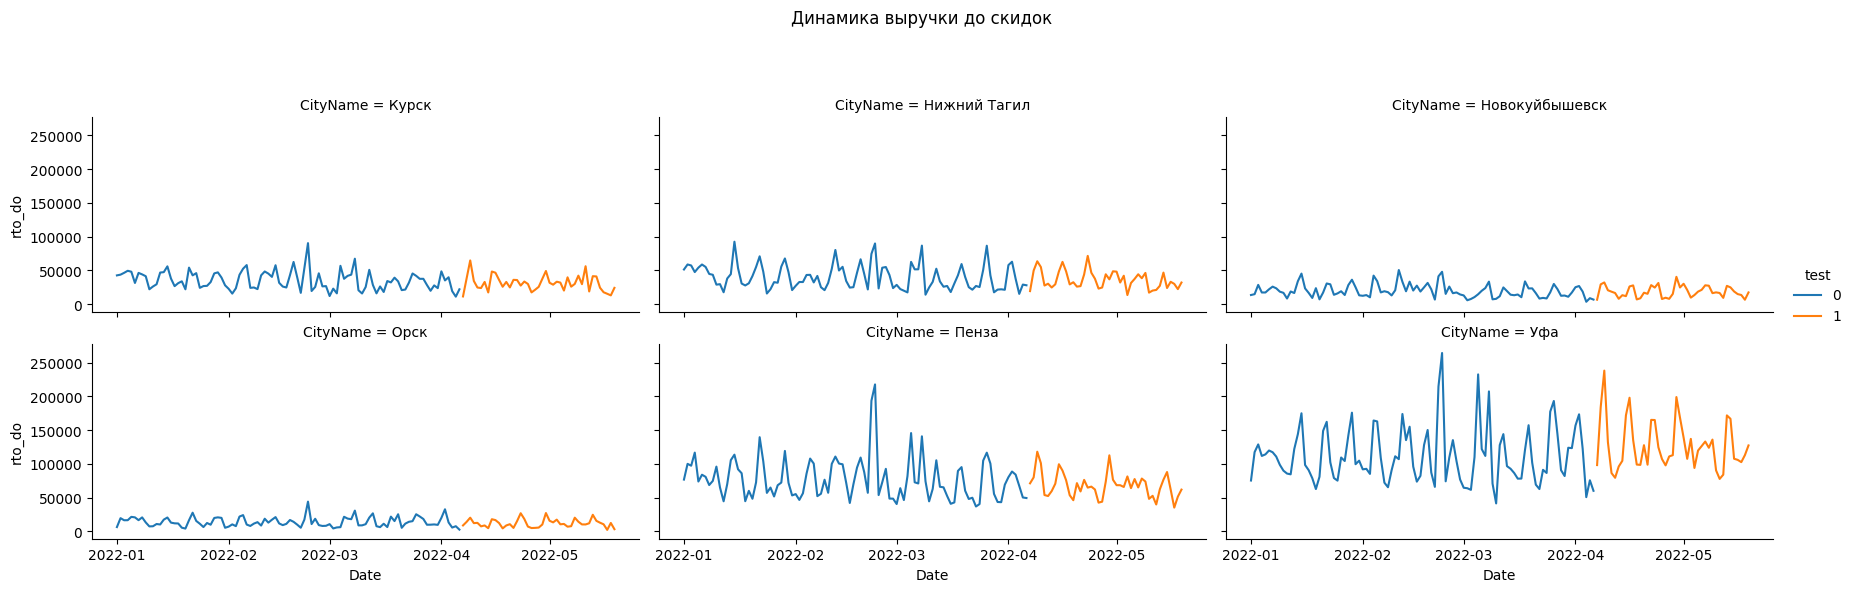

In [15]:
# Plot each year's time series in its own facet

g = sns.relplot( 
    data=d[d["CityName"].isin(test_cities)],
    x="Date", y="rto_do", 
    col="CityName", 
    hue="test", 
    kind = "line", 
    col_wrap=3, 
    height=3, 
    aspect=2,
)
g.fig.subplots_adjust(top=.8)
g.fig.suptitle('Динамика выручки до скидок')


Text(0.5, 0.98, 'Динамика выручки после скидок')

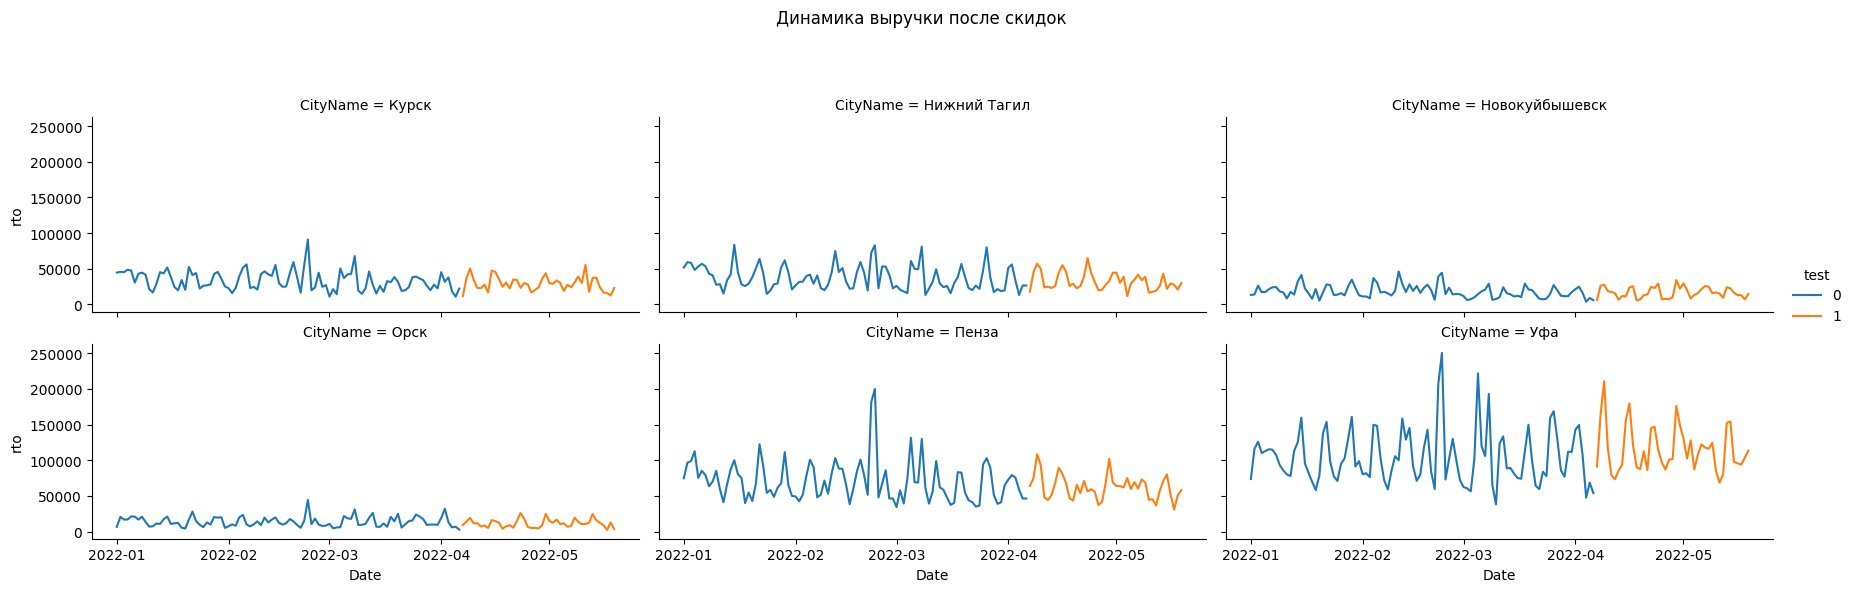

In [16]:
g = sns.relplot( 
    data=d[d["CityName"].isin(test_cities)],
    x="Date", y="rto", 
    col="CityName", 
    hue="test", 
    kind = "line", 
    col_wrap=3, 
    height=3, 
    aspect=2,
)
g.fig.subplots_adjust(top=.8)
g.fig.suptitle('Динамика выручки после скидок')


Text(0.5, 0.98, 'Динамика среднего времени заказа')

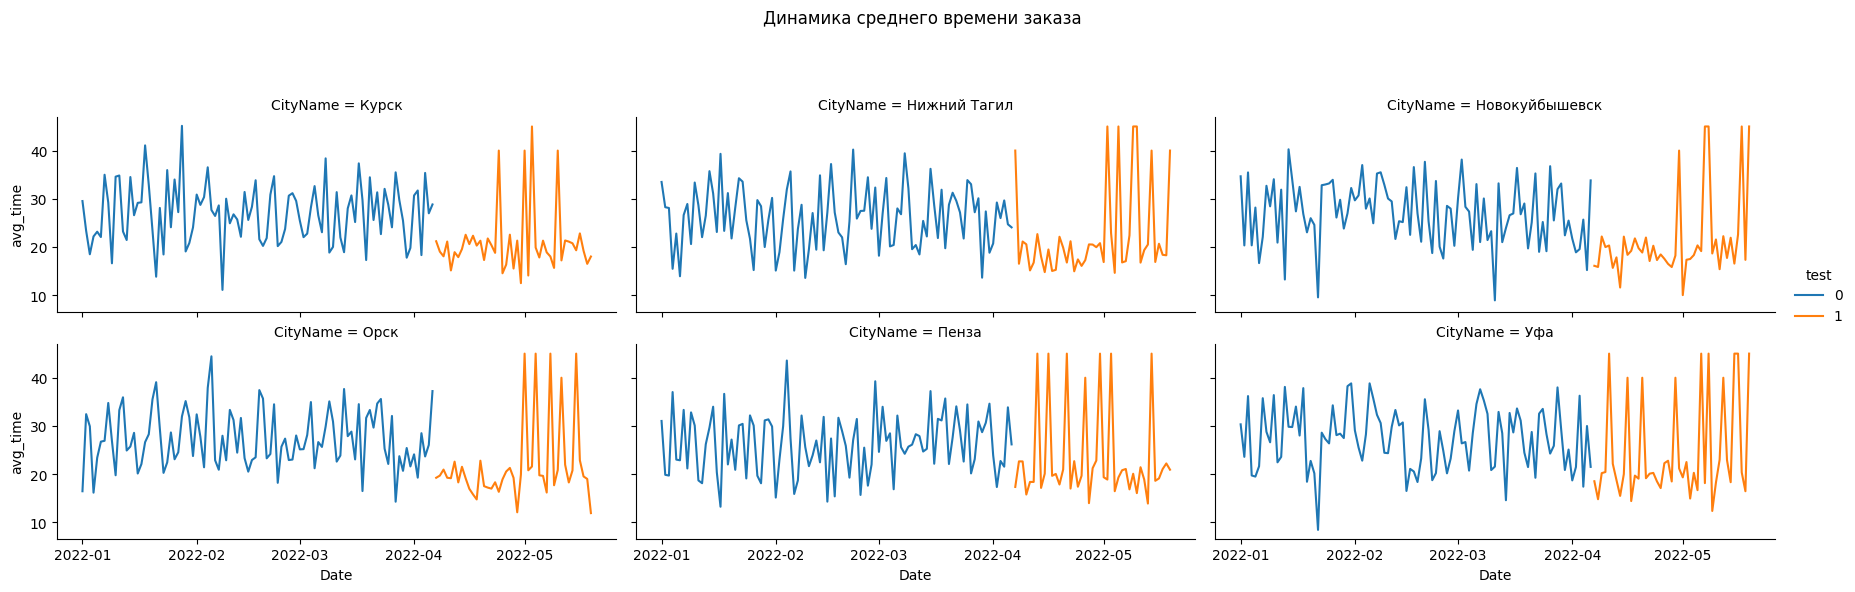

In [17]:
g = sns.relplot( 
    data=d[d["CityName"].isin(test_cities)],
    x="Date", y="avg_time", 
    col="CityName", 
    hue="test", 
    kind = "line", 
    col_wrap=3, 
    height=3, 
    aspect=2,
)

g.fig.subplots_adjust(top=.8)
g.fig.suptitle('Динамика среднего времени заказа')

## Тут и далее остановилась на rto по пицце

Посмотрим на распредление метрики которую я хочу анализировать:
Выручка после скидок по категории пицца

<Axes: xlabel='rto', ylabel='Count'>

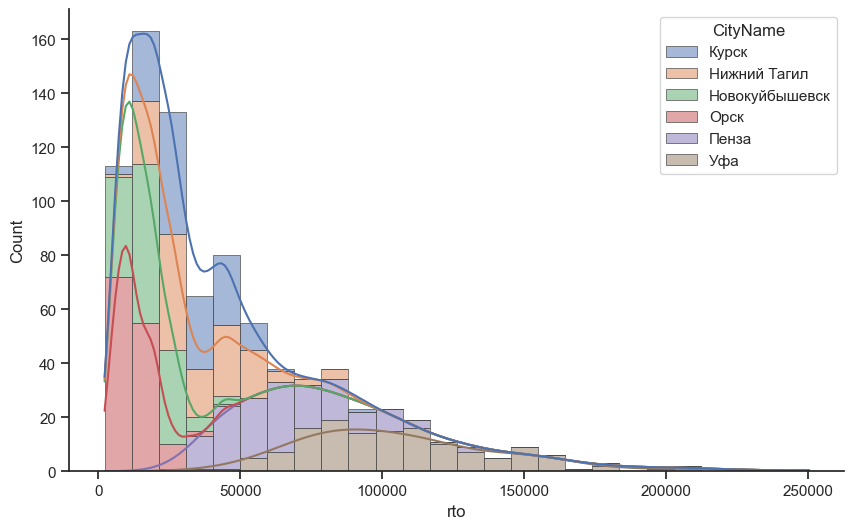

In [18]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)

sns.histplot(
    d[d["CityName"].isin(test_cities)],
    x="rto", hue="CityName",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
    kde = True
)

Мы видем что наши данные распределены логнормально,
Одна из предпосылок t-теста, например, это нормальное распределение
Я хочу (и могу) попробовать поработать с логарифмами выручки.

In [19]:
d["log_rto"] = np.log(d["rto"])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='log_rto', ylabel='Count'>

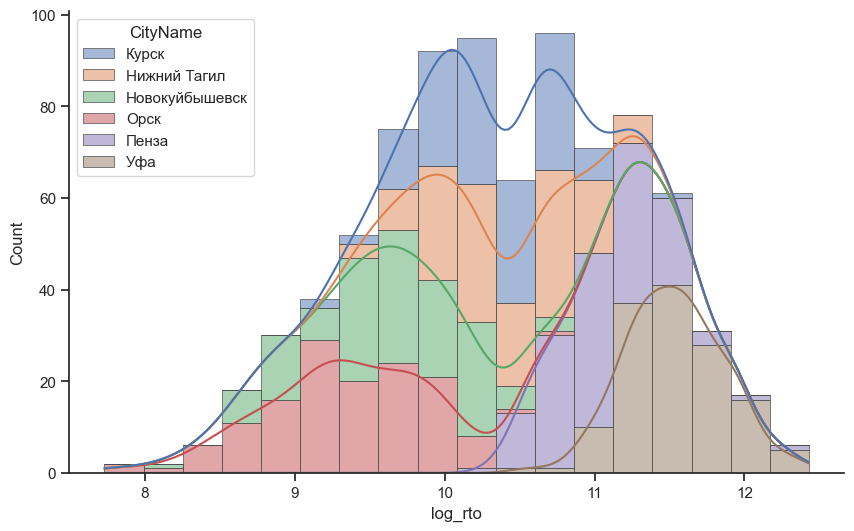

In [20]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)

sns.histplot(
    d[d["CityName"].isin(test_cities)],
    x="log_rto", hue="CityName",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
    kde = True
)

Симпатичные кучки, уже более похожие на нормально распределенные величины, однако внутри каждого тестого города мы видим раздвоение, что может свидетельстовать о том что эффект таки имел место быть. Но давайте взглянем на распределение логарифма выручки в контрольной группе. 

<Axes: xlabel='log_rto', ylabel='Count'>

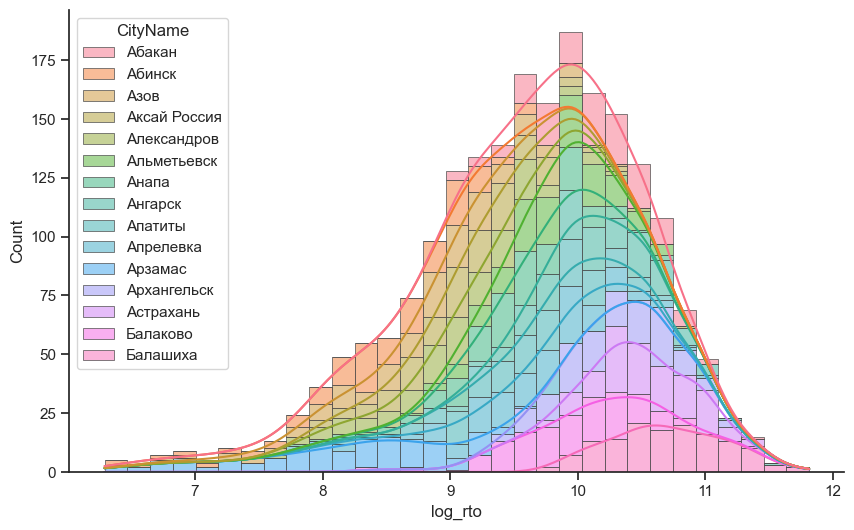

In [21]:
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)

sns.histplot(
    d[d["CityName"].isin(controle_cities[:15])],
    x="log_rto", hue="CityName",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
    kde = True
)

<Axes: xlabel='log_rto', ylabel='Count'>

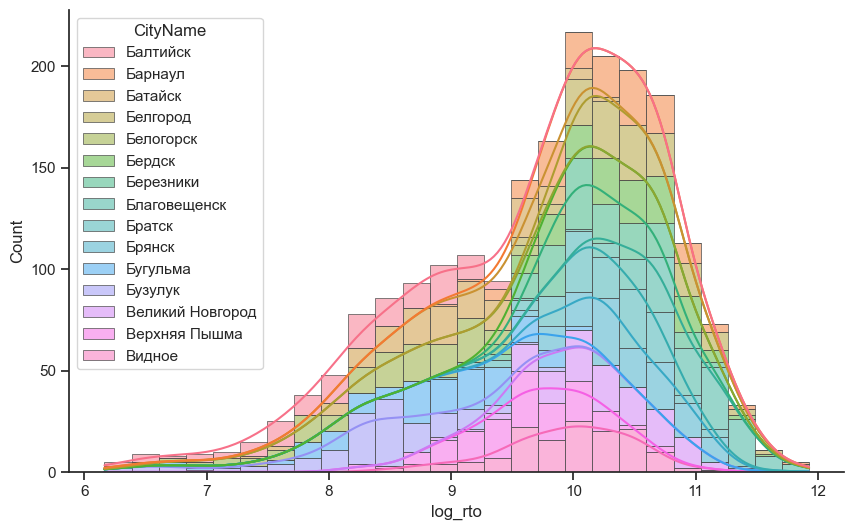

In [22]:
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)

sns.histplot(
    d[d["CityName"].isin(controle_cities[15:30])],
    x="log_rto", hue="CityName",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
    kde = True
)

Тут конечно достаточно разные распределения в контрольной группе, есть очень красивые логнормальные а есть такого же плана двухвершинные. Рано делать какие-либо выводы, кроме того что города разные...

/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_5289/1343617427.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d[d["CityName"].isin(test_cities) & time_before],


                                    Распределение в тестовой выборке до теста


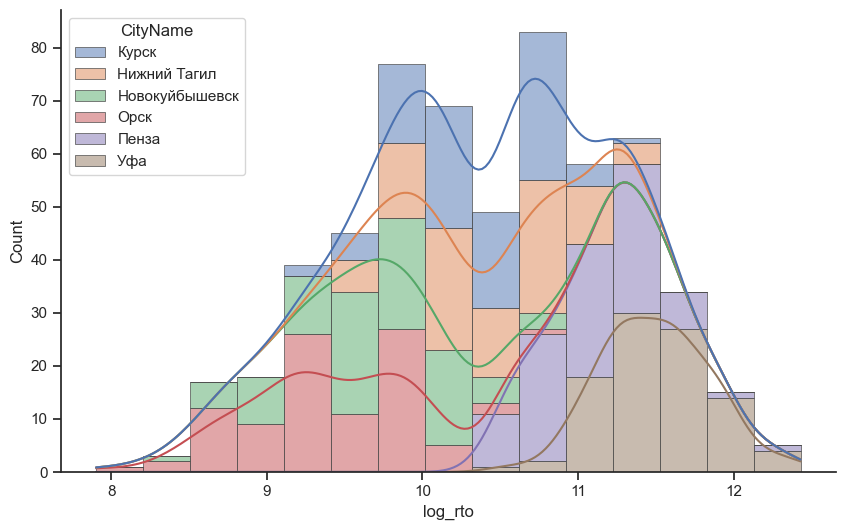

In [23]:
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)

sns.histplot(
    d[d["CityName"].isin(test_cities) & time_before],
    x="log_rto", hue="CityName",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
    kde = True
)
print("                                    Распределение в тестовой выборке до теста")

/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_5289/3367665935.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d[d["CityName"].isin(test_cities) & time_condition],


                                    Распределение в тестовой выборке во время теста


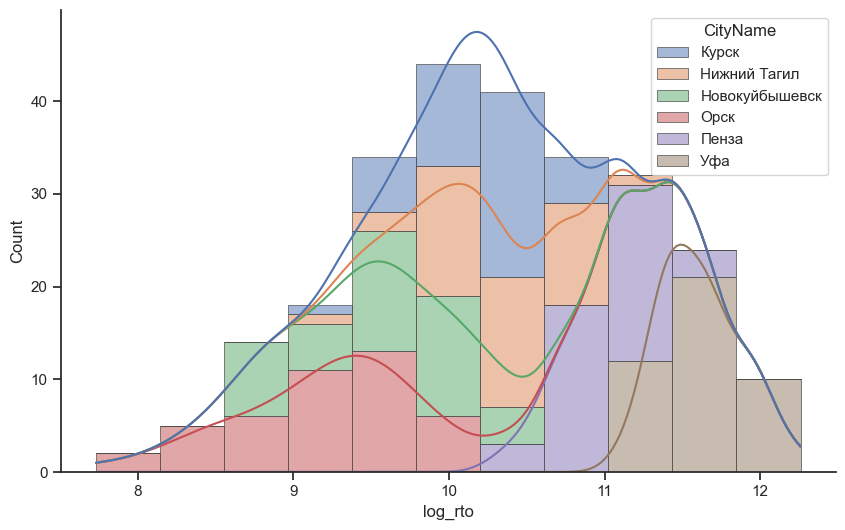

In [24]:
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)

sns.histplot(
    d[d["CityName"].isin(test_cities) & time_condition],
    x="log_rto", hue="CityName",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
    kde = True
)

print("                                    Распределение в тестовой выборке во время теста")

## Еще раз взглянем на динамику, только теперь логарифма

Text(0.5, 0.98, 'Динамика Логвыручки после скидок по пиццам')

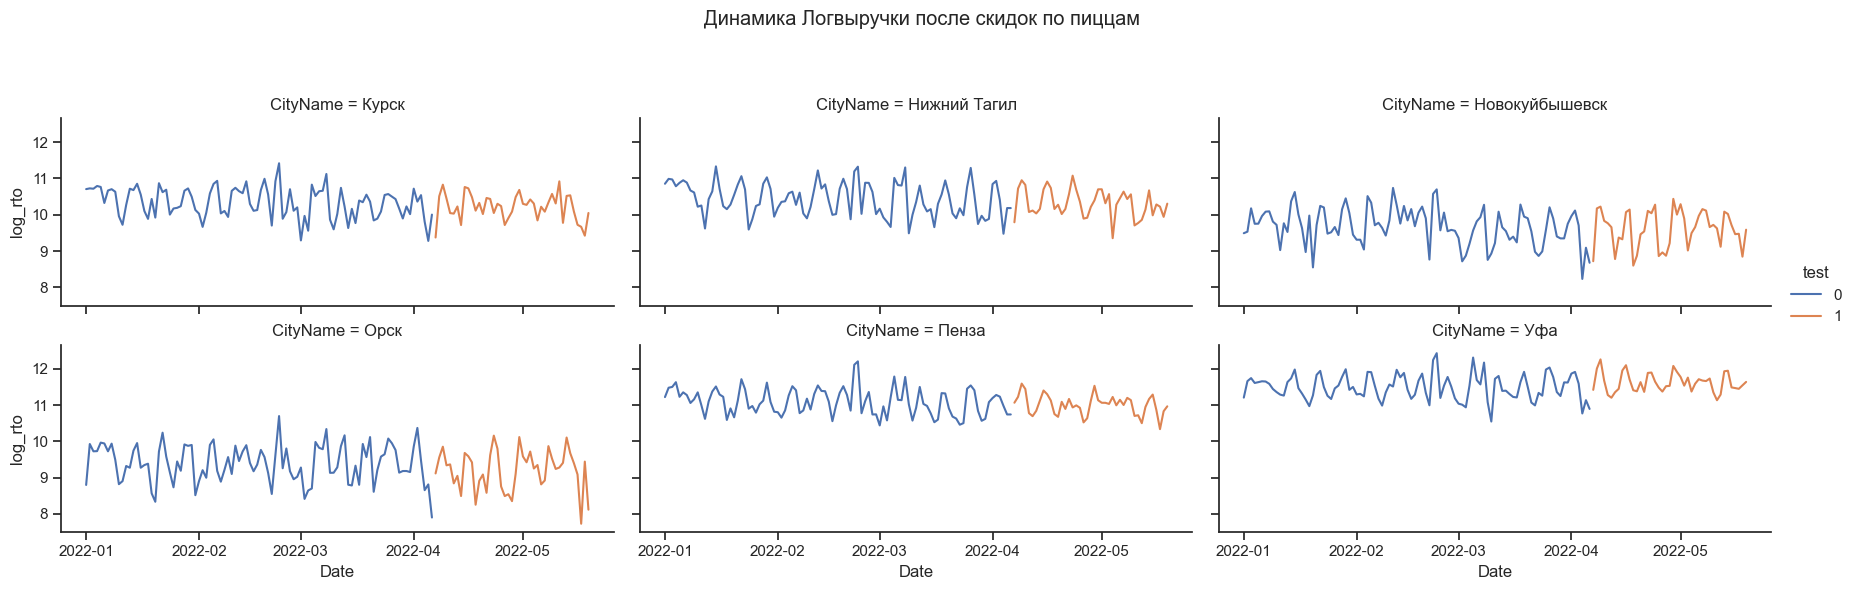

In [25]:
g = sns.relplot( 
    data=d[d["CityName"].isin(test_cities)],
    x="Date", y="log_rto", 
    col="CityName", 
    hue="test", 
    kind = "line", 
    col_wrap=3, 
    height=3, 
    aspect=2,
)
g.fig.subplots_adjust(top=.8)
g.fig.suptitle('Динамика Логвыручки после скидок по пиццам')

## Удалю праздники как выбросы | 23 февраля и 8 марта

Проверила производственный календарь 2022 и в итоге убрала 23 февраля и 6-8 марта.

In [26]:
# 6, 7, 8 марта
# 23 февраля

In [27]:
d.loc[d.Date == "2022-02-23", "rto"] = np.nan
d.loc[d.Date == "2022-02-23", "log_rto"] = np.nan

d.loc[(d.Date >= "2022-03-06") & (d.Date <= "2022-03-08"), "rto"] = np.nan
d.loc[(d.Date >= "2022-03-06") & (d.Date <= "2022-03-08"), "log_rto"] = np.nan

In [28]:
def fill_nulls(X):
    X = (X.ffill()+X.bfill())/2
    X = X.ffill()
    X = X.bfill()
    return X

In [29]:
# Общая таблица
d_pvt = d.pivot_table(index = 'Date', 
                      columns = 'CityName', 
                      values='log_rto')
d_pvt["avg_test_city"] = d_pvt[test_cities].mean(axis = 1)

#Заполняю пропуски
d_pvt = fill_nulls(d_pvt)

In [30]:
for col in d_pvt.columns.values:
    try:
        d_pvt[col + "_trend"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).trend
        d_pvt[col + "_seas"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).seasonal
        d_pvt[col + "_res"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).resid
        d_pvt[col + "_obs"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).observed
        
    except:
        pass
    
for col in ["avg_test_city"]:
    try:
        d_pvt[col + "_trend"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).trend
        d_pvt[col + "_seas"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).seasonal
        d_pvt[col + "_res"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).resid
        d_pvt[col + "_obs"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).observed
        
    except:
        pass

/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_5289/1486933977.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d_pvt[col + "_res"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).resid
/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_5289/1486933977.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  d_pvt[col + "_obs"] = seasonal_decompose(d_pvt[col], extrapolate_trend = 7, period = 7).observed
/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_5289/1486933977.py:3: Performa

In [31]:
# Разделение на датасет до и во время теста
d_pre_treatment = d_pvt[d_pvt.index < "2022-04-07"]
d_treatment = d_pvt[(d_pvt.index >= "2022-04-07") & (d_pvt.index <= "2022-05-19")]

In [32]:
test_cities = ["Пенза", "Уфа", "Курск", "Нижний Тагил", "Новокуйбышевск", "Орск"]

# Заодно создаем и контрольные города
a = test_cities+["Вышний Волочек", "Копейск", "Лабытнанги", "Прокопьевск"]
controle_cities = [city for city in d.CityName.unique() if city not in a]

test_cities_tr = [city + "_trend" for city in test_cities]
controle_cities_tr = [city + "_trend" for city in controle_cities]

# Датасет с данными до теста с тестовыми городами
d_pre_treatment_test = d_pre_treatment[test_cities_tr]

# Датасет с данными до теста с контрольными городами
d_pre_treatment_control = d_pre_treatment[controle_cities_tr]

# Датасет с данными во время проведения теста с тестовыми городами
d_treatment_test  = d_treatment[test_cities_tr]

# Датасет с данными во время проведения теста с контрольными городами
d_treatment_control = d_treatment[controle_cities_tr]

In [34]:
d_treatment_control

CityName,Абакан_trend,Абинск_trend,Азов_trend,Аксай Россия_trend,Александров_trend,Альметьевск_trend,Анапа_trend,Ангарск_trend,Апатиты_trend,Апрелевка_trend,...,Шлиссельбург_trend,Шушары_trend,Щелково_trend,Щербинка_trend,Электросталь_trend,Электроугли_trend,Энгельс_trend,Югорск_trend,Южно-Сахалинск_trend,Якутск_trend
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-07 00:00:00+00:00,9.815867,8.299606,8.352959,8.936068,9.355393,9.626188,9.511474,10.104768,9.712189,9.693969,...,9.015701,9.498863,10.575842,10.737379,10.088118,8.440198,9.707363,9.470585,10.929527,10.757800
2022-04-08 00:00:00+00:00,9.786517,8.374879,8.436722,9.072793,9.209682,9.645257,9.457134,10.057504,9.716127,9.591401,...,8.860013,9.246160,10.628667,10.731585,10.034983,8.533436,9.556835,9.479491,11.006923,10.738713
2022-04-09 00:00:00+00:00,9.809048,8.584293,8.651526,9.068584,9.147685,9.626843,9.594924,10.131108,9.598652,9.479451,...,8.870043,9.149087,10.560641,10.817884,10.052048,8.777215,9.561073,9.485744,11.009748,10.725123
2022-04-10 00:00:00+00:00,9.843527,8.889928,8.746214,9.171082,9.079333,9.554788,9.560975,10.105450,9.505558,9.389706,...,8.631637,9.176569,10.597556,10.851211,9.996789,8.784849,9.584027,9.220480,10.995963,10.800660
2022-04-11 00:00:00+00:00,9.927544,8.680675,8.711028,9.194034,8.998923,9.586083,9.491965,10.049853,9.497698,9.305705,...,8.570798,9.129028,10.495682,10.804262,9.889351,8.836266,9.552290,9.098626,10.968671,10.850470
2022-04-12 00:00:00+00:00,9.908138,8.588761,8.855754,9.123095,9.055347,9.651467,9.597757,10.007830,9.492563,9.276760,...,8.533951,9.127484,10.503180,10.801652,9.882957,8.728364,9.544205,9.087165,10.991660,10.821150
2022-04-13 00:00:00+00:00,9.864237,8.572924,8.872859,9.146285,8.942814,9.727130,9.628371,9.995760,9.455353,9.275586,...,8.469510,9.165545,10.514720,10.803669,9.914712,8.751550,9.558545,9.117121,10.989262,10.821898
2022-04-14 00:00:00+00:00,9.836202,8.412435,8.825475,9.161511,8.978871,9.785160,9.609514,9.971662,9.510897,9.345171,...,8.284176,9.282369,10.487843,10.740994,9.898449,8.655803,9.601974,9.125079,10.985643,10.797204
2022-04-15 00:00:00+00:00,9.991017,8.205729,8.770104,9.161603,8.949354,9.729510,9.648621,9.949933,9.613958,9.327386,...,8.206608,9.400874,10.385577,10.762025,9.826373,8.541102,9.699766,8.874765,10.876371,10.803262


# Тестирование

Для построения теста после ресерча я решила остановиться на технике Синтетического контроля, для построения контрольной выборки. Для простоты изложения я схематично опишу шаги которые я предпренимала.

Сначала я тестировала отдельно каждый город из тестовой выборки, затем оценила средневзвешенный эффект

### Ограничения моей модели состоят в том что:

1. Я не знаю каким образом подбирались тестовые города. Они имеют различные первоначальные распределения в данных. 
2. Я исключила 4 города из контрольной выборки из анализа так как на них некорректно отрабатовало сезонное сглаживание.
3. История данных не позволяет корректно оценить сезонность более высоких порядков, напремер годовую, что может значительно снизить качество выводов которые мы можем сделать на основе проведенных тестов.
4. Средние значения я заполняла средними, а затем "тем что осталось". В моем понимании иногда лучше дропнуть точку в такой ситуации нежели её искусственно заполнять, но сложный выбор - сохранить точки или дропнуть. И если дропать точки сезонная декомпозиция не сработает адекватно.


### Ход теста:

1. Взяла логарифм от выручки по пицце и далее работала с ним, так как визуально выручка была распределена логнормально
2. Сделала аддитивную сеззонную декомпозицию, выделила тренд, сезонность и шоки и сохранила эти результаты для каждого города.
3. На каждый тестовый город я регрессировала топ 30 самых близких по корреляции городов, тем самымм я настроила веса для синтетического города методом наименьших квадратов.
4. На данном этапе я получила тренд тестового города и тренд синтетического города.
5. По сохраненной сезонности я восстановила ряд синтетического города и назвала его _recovered
6. Провела тест Стюдента для восстановленного синтетического города и для тетстового города который мы наблюдалии.
7. Получила абсолютный и относительный эффект а так же значимость для каждого города.




In [33]:
# вспомогательные словари
w = {}
m_test = {}
m_control = {}
std_test = {}
std_control = {}
eff = {}

## Пенза

p-value for two tailed: 0.2879063450253739
p-value for one tailed: 0.14395317251268694

Effect for log_rto: 0.06
Relative effect for rto: 1.07. Выручка в экспереминтальном городе на 6.66 % выше.

Результаты теста не значимы.


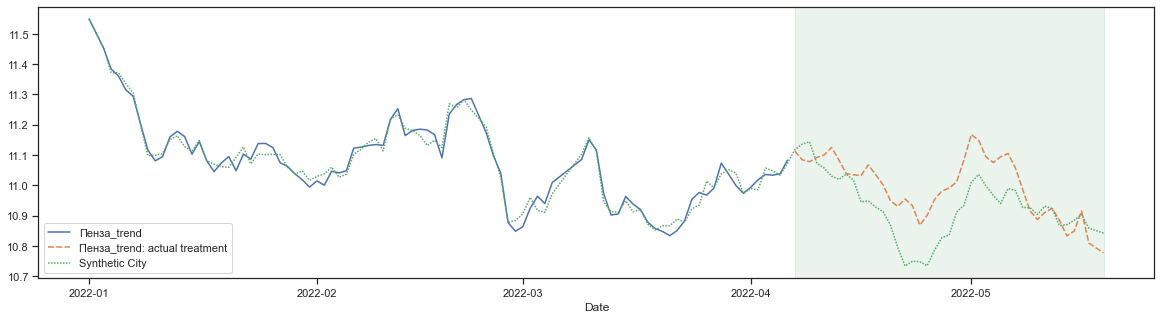

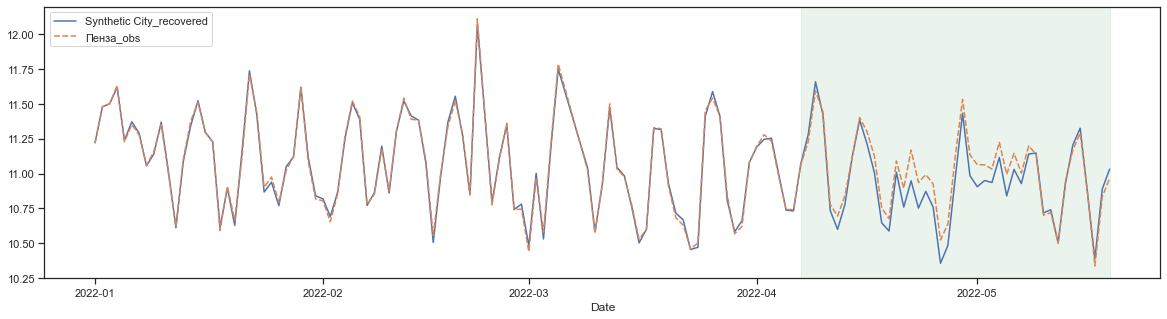

In [34]:
test_cities = ["Пенза", "Уфа", "Курск", "Нижний Тагил", "Новокуйбышевск", "Орск"]

# Заодно создаем и контрольные города
a = test_cities+["Вышний Волочек", "Копейск", "Лабытнанги", "Прокопьевск"]
controle_cities = [city for city in d.CityName.unique() if city not in a]

test_cities_tr = [city + "_trend" for city in test_cities]
controle_cities_tr = [city + "_trend" for city in controle_cities]

# Датасет с данными до теста с тестовыми городами
d_pre_treatment_test = d_pre_treatment[test_cities_tr]

# Датасет с данными до теста с контрольными городами
d_pre_treatment_control = d_pre_treatment[controle_cities_tr]

# Датасет с данными во время проведения теста с тестовыми городами
d_treatment_test  = d_treatment[test_cities_tr]

# Датасет с данными во время проведения теста с контрольными городами
d_treatment_control = d_treatment[controle_cities_tr]

city_name = test_cities_tr[0]
y = d_pre_treatment_test[city_name]
X = d_pre_treatment_control

# Выбираю топ 30 городов которые коррелируют с выбранным сильнее всего
top_N = 30

selected_cities = {}
for col in X.columns:
    selected_cities[col] = np.corrcoef(y, X[col])[0][1]

selected_cities = [k for k,v in Counter(selected_cities).most_common(top_N)]

# Настраиваем веса синтетического города с помощью линейной регрессии
regr = LinearRegression().fit(X[selected_cities], y)

# Создаем синтетический город
synthetic_city  = regr.predict(X[selected_cities])

# Заполняем пропуски
d_treatment_control = fill_nulls(d_treatment_control[selected_cities])

# Предстказанный синтетический город
city_predicted  = regr.predict(d_treatment_control[selected_cities])

city_treatment = d_treatment_test[city_name].reset_index()
city_treatment.columns = ['Date', city_name + ': actual treatment']

# Датасет для визуализации
df_comb = y.reset_index().append(city_treatment).reset_index(drop=True)
df_comb['Synthetic City'] = list(synthetic_city) + list(city_predicted)
df_comb.columns = ['Date', city_name, city_name+': actual treatment', 'Synthetic City']
df_comb.Date = pd.to_datetime(df_comb.Date, utc=True)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb.set_index('Date'))
ax.axvspan(list(df_comb.Date)[-43], list(df_comb.Date)[-1], color='g', alpha = 0.12)

#city_name = test_cities[0] 
city_name = city_name[:-6]
tmp = d_pvt[[f"{city_name}_seas", f"{city_name}_trend", f"{city_name}_res", f"{city_name}_obs"]]

# Восстановим исходные ряды:
df_comb = pd.merge(df_comb, tmp, how = "left", left_on = "Date", right_on = tmp.index)
df_comb["Synthetic City_recovered"] = df_comb["Synthetic City"] + df_comb[f"{city_name}_seas"] + df_comb[f"{city_name}_res"]
df_comb_rec = df_comb[['Date', 'Synthetic City_recovered', f'{city_name}_obs']]

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb_rec.set_index('Date'))
ax.axvspan(list(df_comb_rec.Date)[-43], list(df_comb_rec.Date)[-1], color='g', alpha = 0.12) 

test_df = df_comb_rec[df_comb_rec.Date >= "2022-04-07"]

n = len(test_df)

#### H0 средние равны (в синтетическом городе и в обозримом городе из тестовой выборки)

#### H1 средние не равны

test_df.head()

m2 = test_df["Synthetic City_recovered"].mean()
s2 = test_df["Synthetic City_recovered"].std()

m1 = test_df[f"{city_name}_obs"].mean()
s1 = test_df[f"{city_name}_obs"].std()
df = n + n - 2

w[city_name] = m1
m_test[city_name] = m1
m_control[city_name] = m2
std_test[city_name] = s1
std_control[city_name] = s2
eff[city_name] = m1 - m2

t_st = (m1 - m2)/ np.sqrt(s1**2/n + s2**2/n)
t_st

# get two-tailed p value
p_two = 2*stats.t.sf(abs(t_st), df=df)
print("p-value for two tailed:",p_two)

# get one-tailed p value
p_one = stats.t.sf(abs(t_st), df=df)
print("p-value for one tailed:",p_one)

effect = (m1 - m2)
relative_effect = np.exp(effect)

print()
print(f"Effect for log_rto: {effect:.2f}")
print(f"Relative effect for rto: {relative_effect:.2f}. Выручка в экспереминтальном городе на {(-1 + relative_effect)*100:.2f} % выше.")

print()
print("Результаты теста не значимы.")

## Уфа

p-value for two tailed: 0.015687655631193183
p-value for one tailed: 0.007843827815596591

Effect for log_rto: 0.14
Relative effect for rto: 1.15. Выручка в экспереминтальном городе на 15.19 % выше.

Результаты теста значимы на 1% уровне значимости для односторонненого теста


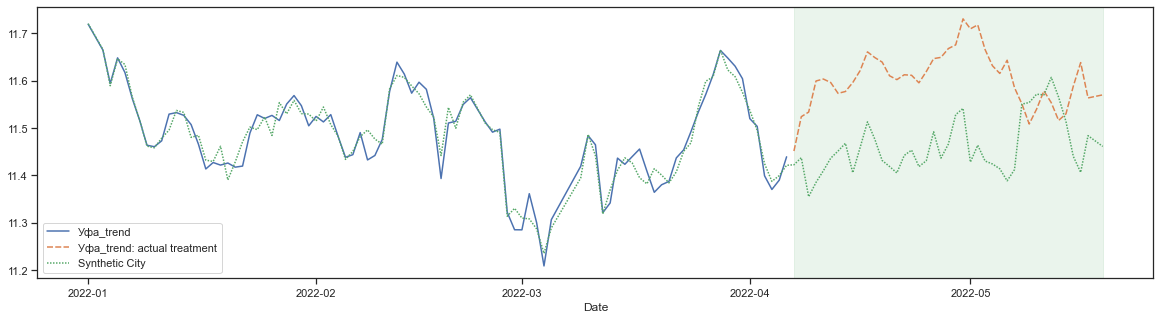

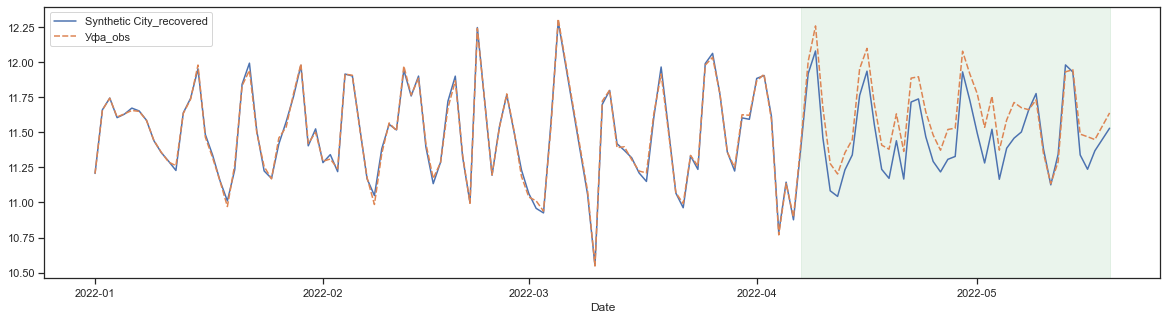

In [35]:
test_cities = ["Пенза", "Уфа", "Курск", "Нижний Тагил", "Новокуйбышевск", "Орск"]

# Заодно создаем и контрольные города
a = test_cities+["Вышний Волочек", "Копейск", "Лабытнанги", "Прокопьевск"]
controle_cities = [city for city in d.CityName.unique() if city not in a]

test_cities_tr = [city + "_trend" for city in test_cities]
controle_cities_tr = [city + "_trend" for city in controle_cities]

# Датасет с данными до теста с тестовыми городами
d_pre_treatment_test = d_pre_treatment[test_cities_tr]

# Датасет с данными до теста с контрольными городами
d_pre_treatment_control = d_pre_treatment[controle_cities_tr]

# Датасет с данными во время проведения теста с тестовыми городами
d_treatment_test  = d_treatment[test_cities_tr]

# Датасет с данными во время проведения теста с контрольными городами
d_treatment_control = d_treatment[controle_cities_tr]

city_name = test_cities_tr[1]
y = d_pre_treatment_test[city_name]
X = d_pre_treatment_control

# Выбираю топ 30 городов которые коррелируют с выбранным сильнее всего
top_N = 30

selected_cities = {}
for col in X.columns:
    selected_cities[col] = np.corrcoef(y, X[col])[0][1]

selected_cities = [k for k,v in Counter(selected_cities).most_common(top_N)]

# Настраиваем веса синтетического города с помощью линейной регрессии
regr = LinearRegression().fit(X[selected_cities], y)

# Создаем синтетический город
synthetic_city  = regr.predict(X[selected_cities])

# Заполняем пропуски
d_treatment_control = fill_nulls(d_treatment_control[selected_cities])

# Предстказанный синтетический город
city_predicted  = regr.predict(d_treatment_control[selected_cities])

city_treatment = d_treatment_test[city_name].reset_index()
city_treatment.columns = ['Date', city_name + ': actual treatment']

# Датасет для визуализации
df_comb = y.reset_index().append(city_treatment).reset_index(drop=True)
df_comb['Synthetic City'] = list(synthetic_city) + list(city_predicted)
df_comb.columns = ['Date', city_name, city_name+': actual treatment', 'Synthetic City']
df_comb.Date = pd.to_datetime(df_comb.Date, utc=True)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb.set_index('Date'))
ax.axvspan(list(df_comb.Date)[-43], list(df_comb.Date)[-1], color='g', alpha = 0.12)

#city_name = test_cities[0] 
city_name = city_name[:-6]
tmp = d_pvt[[f"{city_name}_seas", f"{city_name}_trend", f"{city_name}_res", f"{city_name}_obs"]]

# Восстановим исходные ряды:
df_comb = pd.merge(df_comb, tmp, how = "left", left_on = "Date", right_on = tmp.index)
df_comb["Synthetic City_recovered"] = df_comb["Synthetic City"] + df_comb[f"{city_name}_seas"] + df_comb[f"{city_name}_res"]
df_comb_rec = df_comb[['Date', 'Synthetic City_recovered', f'{city_name}_obs']]

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb_rec.set_index('Date'))
ax.axvspan(list(df_comb_rec.Date)[-43], list(df_comb_rec.Date)[-1], color='g', alpha = 0.12) 

test_df = df_comb_rec[df_comb_rec.Date >= "2022-04-07"]

n = len(test_df)

#### H0 средние равны (в синтетическом городе и в обозримом городе из тестовой выборки)

#### H1 средние не равны

test_df.head()

m2 = test_df["Synthetic City_recovered"].mean()
s2 = test_df["Synthetic City_recovered"].std()

m1 = test_df[f"{city_name}_obs"].mean()
s1 = test_df[f"{city_name}_obs"].std()
df = n + n - 2

w[city_name] = m1
m_test[city_name] = m1
m_control[city_name] = m2
std_test[city_name] = s1
std_control[city_name] = s2
eff[city_name] = m1 - m2

t_st = (m1 - m2)/ np.sqrt(s1**2/n + s2**2/n)
t_st

# get two-tailed p value
p_two = 2*stats.t.sf(abs(t_st), df=df)
print("p-value for two tailed:",p_two)

# get one-tailed p value
p_one = stats.t.sf(abs(t_st), df=df)
print("p-value for one tailed:",p_one)

effect = (m1 - m2)
relative_effect = np.exp(effect)

print()
print(f"Effect for log_rto: {effect:.2f}")
print(f"Relative effect for rto: {relative_effect:.2f}. Выручка в экспереминтальном городе на {(-1 + relative_effect)*100:.2f} % выше.")

print()
print("Результаты теста значимы на 1% уровне значимости для односторонненого теста")

## Курск

p-value for two tailed: 0.1451809951696231
p-value for one tailed: 0.07259049758481155

Effect for log_rto: 0.11
Relative effect for rto: 1.12. Выручка в экспереминтальном городе на 11.85 % выше.

Результаты значимы на 10% уровне значимости для одностороненнего теста


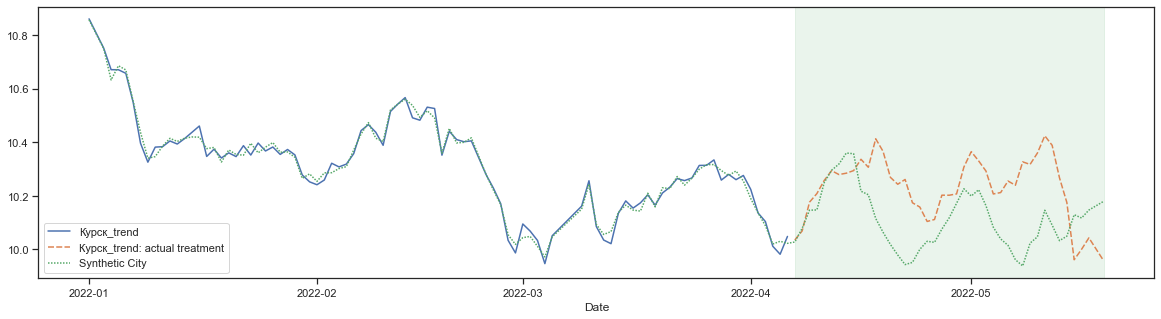

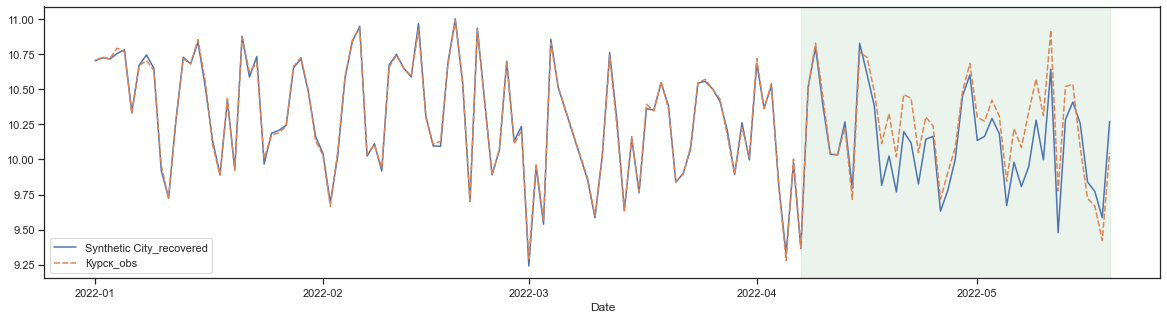

In [36]:
test_cities = ["Пенза", "Уфа", "Курск", "Нижний Тагил", "Новокуйбышевск", "Орск"]

# Заодно создаем и контрольные города
a = test_cities+["Вышний Волочек", "Копейск", "Лабытнанги", "Прокопьевск"]
controle_cities = [city for city in d.CityName.unique() if city not in a]

test_cities_tr = [city + "_trend" for city in test_cities]
controle_cities_tr = [city + "_trend" for city in controle_cities]

# Датасет с данными до теста с тестовыми городами
d_pre_treatment_test = d_pre_treatment[test_cities_tr]

# Датасет с данными до теста с контрольными городами
d_pre_treatment_control = d_pre_treatment[controle_cities_tr]

# Датасет с данными во время проведения теста с тестовыми городами
d_treatment_test  = d_treatment[test_cities_tr]

# Датасет с данными во время проведения теста с контрольными городами
d_treatment_control = d_treatment[controle_cities_tr]

city_name = test_cities_tr[2]
y = d_pre_treatment_test[city_name]
X = d_pre_treatment_control

# Выбираю топ 30 городов которые коррелируют с выбранным сильнее всего
top_N = 30

selected_cities = {}
for col in X.columns:
    selected_cities[col] = np.corrcoef(y, X[col])[0][1]

selected_cities = [k for k,v in Counter(selected_cities).most_common(top_N)]

# Настраиваем веса синтетического города с помощью линейной регрессии
regr = LinearRegression().fit(X[selected_cities], y)

# Создаем синтетический город
synthetic_city  = regr.predict(X[selected_cities])

# Заполняем пропуски
d_treatment_control = fill_nulls(d_treatment_control[selected_cities])

# Предстказанный синтетический город
city_predicted  = regr.predict(d_treatment_control[selected_cities])

city_treatment = d_treatment_test[city_name].reset_index()
city_treatment.columns = ['Date', city_name + ': actual treatment']

# Датасет для визуализации
df_comb = y.reset_index().append(city_treatment).reset_index(drop=True)
df_comb['Synthetic City'] = list(synthetic_city) + list(city_predicted)
df_comb.columns = ['Date', city_name, city_name+': actual treatment', 'Synthetic City']
df_comb.Date = pd.to_datetime(df_comb.Date, utc=True)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb.set_index('Date'))
ax.axvspan(list(df_comb.Date)[-43], list(df_comb.Date)[-1], color='g', alpha = 0.12)

#city_name = test_cities[0] 
city_name = city_name[:-6]
tmp = d_pvt[[f"{city_name}_seas", f"{city_name}_trend", f"{city_name}_res", f"{city_name}_obs"]]

# Восстановим исходные ряды:
df_comb = pd.merge(df_comb, tmp, how = "left", left_on = "Date", right_on = tmp.index)
df_comb["Synthetic City_recovered"] = df_comb["Synthetic City"] + df_comb[f"{city_name}_seas"] + df_comb[f"{city_name}_res"]
df_comb_rec = df_comb[['Date', 'Synthetic City_recovered', f'{city_name}_obs']]

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb_rec.set_index('Date'))
ax.axvspan(list(df_comb_rec.Date)[-43], list(df_comb_rec.Date)[-1], color='g', alpha = 0.12) 

test_df = df_comb_rec[df_comb_rec.Date >= "2022-04-07"]

n = len(test_df)

#### H0 средние равны (в синтетическом городе и в обозримом городе из тестовой выборки)

#### H1 средние не равны

test_df.head()

m2 = test_df["Synthetic City_recovered"].mean()
s2 = test_df["Synthetic City_recovered"].std()

m1 = test_df[f"{city_name}_obs"].mean()
s1 = test_df[f"{city_name}_obs"].std()

w[city_name] = m1
m_test[city_name] = m1
m_control[city_name] = m2
std_test[city_name] = s1
std_control[city_name] = s2
eff[city_name] = m1 - m2

df = n + n - 2

t_st = (m1 - m2)/ np.sqrt(s1**2/n + s2**2/n)
t_st

# get two-tailed p value
p_two = 2*stats.t.sf(abs(t_st), df=df)
print("p-value for two tailed:",p_two)

# get one-tailed p value
p_one = stats.t.sf(abs(t_st), df=df)
print("p-value for one tailed:",p_one)

effect = (m1 - m2)
relative_effect = np.exp(effect)

print()
print(f"Effect for log_rto: {effect:.2f}")
print(f"Relative effect for rto: {relative_effect:.2f}. Выручка в экспереминтальном городе на {(-1 + relative_effect)*100:.2f} % выше.")

print()
print("Результаты значимы на 10% уровне значимости для одностороненнего теста")

## Нижний тагил

p-value for two tailed: 0.051514384040633625
p-value for one tailed: 0.025757192020316812

Effect for log_rto: 0.16
Relative effect for rto: 1.17. Выручка в экспереминтальном городе на 17.13 % выше.

Результаты значимы на 5% уровне для одностороннего теста


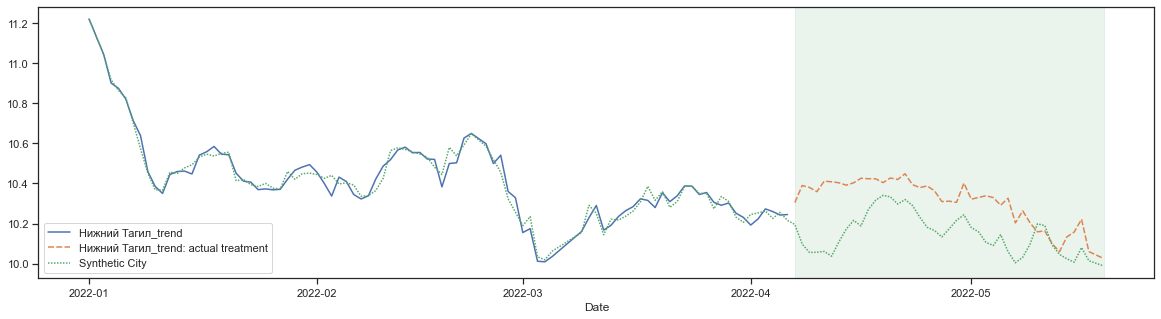

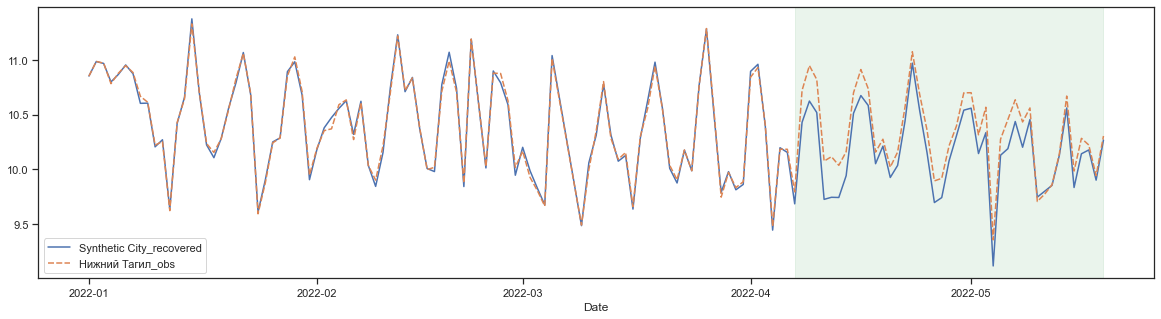

In [37]:
test_cities = ["Пенза", "Уфа", "Курск", "Нижний Тагил", "Новокуйбышевск", "Орск"]

# Заодно создаем и контрольные города
a = test_cities+["Вышний Волочек", "Копейск", "Лабытнанги", "Прокопьевск"]
controle_cities = [city for city in d.CityName.unique() if city not in a]

test_cities_tr = [city + "_trend" for city in test_cities]
controle_cities_tr = [city + "_trend" for city in controle_cities]

# Датасет с данными до теста с тестовыми городами
d_pre_treatment_test = d_pre_treatment[test_cities_tr]

# Датасет с данными до теста с контрольными городами
d_pre_treatment_control = d_pre_treatment[controle_cities_tr]

# Датасет с данными во время проведения теста с тестовыми городами
d_treatment_test  = d_treatment[test_cities_tr]

# Датасет с данными во время проведения теста с контрольными городами
d_treatment_control = d_treatment[controle_cities_tr]

city_name = test_cities_tr[3]
y = d_pre_treatment_test[city_name]
X = d_pre_treatment_control

# Выбираю топ 30 городов которые коррелируют с выбранным сильнее всего
top_N = 30

selected_cities = {}
for col in X.columns:
    selected_cities[col] = np.corrcoef(y, X[col])[0][1]

selected_cities = [k for k,v in Counter(selected_cities).most_common(top_N)]

# Настраиваем веса синтетического города с помощью линейной регрессии
regr = LinearRegression().fit(X[selected_cities], y)

# Создаем синтетический город
synthetic_city  = regr.predict(X[selected_cities])

# Заполняем пропуски
d_treatment_control = fill_nulls(d_treatment_control[selected_cities])

# Предстказанный синтетический город
city_predicted  = regr.predict(d_treatment_control[selected_cities])

city_treatment = d_treatment_test[city_name].reset_index()
city_treatment.columns = ['Date', city_name + ': actual treatment']

# Датасет для визуализации
df_comb = y.reset_index().append(city_treatment).reset_index(drop=True)
df_comb['Synthetic City'] = list(synthetic_city) + list(city_predicted)
df_comb.columns = ['Date', city_name, city_name+': actual treatment', 'Synthetic City']
df_comb.Date = pd.to_datetime(df_comb.Date, utc=True)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb.set_index('Date'))
ax.axvspan(list(df_comb.Date)[-43], list(df_comb.Date)[-1], color='g', alpha = 0.12)

#city_name = test_cities[0] 
city_name = city_name[:-6]
tmp = d_pvt[[f"{city_name}_seas", f"{city_name}_trend", f"{city_name}_res", f"{city_name}_obs"]]

# Восстановим исходные ряды:
df_comb = pd.merge(df_comb, tmp, how = "left", left_on = "Date", right_on = tmp.index)
df_comb["Synthetic City_recovered"] = df_comb["Synthetic City"] + df_comb[f"{city_name}_seas"] + df_comb[f"{city_name}_res"]
df_comb_rec = df_comb[['Date', 'Synthetic City_recovered', f'{city_name}_obs']]

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb_rec.set_index('Date'))
ax.axvspan(list(df_comb_rec.Date)[-43], list(df_comb_rec.Date)[-1], color='g', alpha = 0.12) 

test_df = df_comb_rec[df_comb_rec.Date >= "2022-04-07"]

n = len(test_df)

#### H0 средние равны (в синтетическом городе и в обозримом городе из тестовой выборки)

#### H1 средние не равны

test_df.head()

m2 = test_df["Synthetic City_recovered"].mean()
s2 = test_df["Synthetic City_recovered"].std()

m1 = test_df[f"{city_name}_obs"].mean()
s1 = test_df[f"{city_name}_obs"].std()
df = n + n - 2

w[city_name] = m1
m_test[city_name] = m1
m_control[city_name] = m2
std_test[city_name] = s1
std_control[city_name] = s2
eff[city_name] = m1 - m2

t_st = (m1 - m2)/ np.sqrt(s1**2/n + s2**2/n)
t_st

# get two-tailed p value
p_two = 2*stats.t.sf(abs(t_st), df=df)
print("p-value for two tailed:",p_two)

# get one-tailed p value
p_one = stats.t.sf(abs(t_st), df=df)
print("p-value for one tailed:",p_one)

effect = (m1 - m2)
relative_effect = np.exp(effect)

print()
print(f"Effect for log_rto: {effect:.2f}")
print(f"Relative effect for rto: {relative_effect:.2f}. Выручка в экспереминтальном городе на {(- 1 + relative_effect)*100:.2f} % выше.")

print()
print("Результаты значимы на 5% уровне для одностороннего теста")

## Новокуйбышевск

p-value for two tailed: 0.3857153577153912
p-value for one tailed: 0.1928576788576956

Effect for log_rto: -0.09
Relative effect for rto: 0.91. Выручка в экспереминтальном городе на 8.87 % ниже.

Результаты теста не значимы


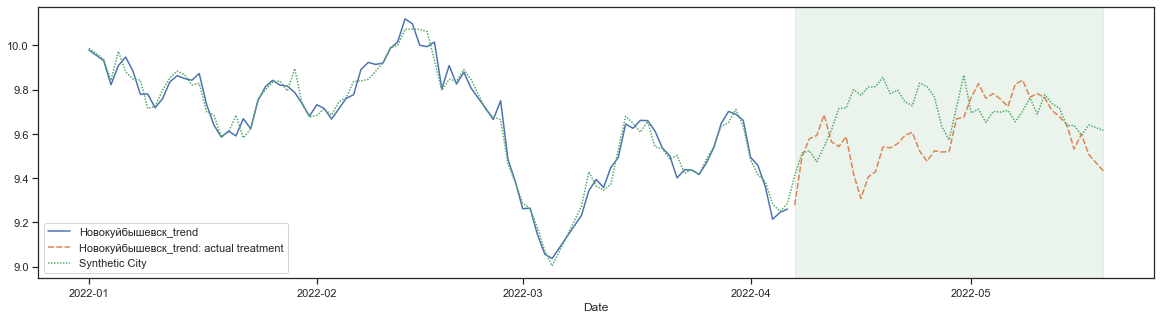

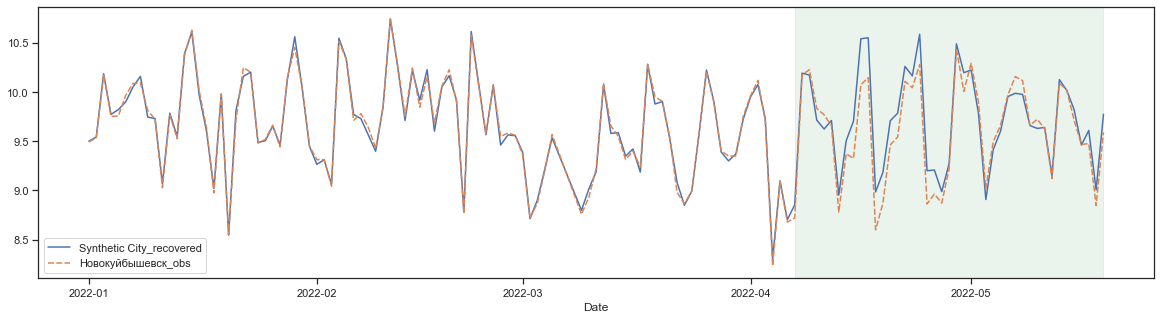

In [38]:
test_cities = ["Пенза", "Уфа", "Курск", "Нижний Тагил", "Новокуйбышевск", "Орск"]

# Заодно создаем и контрольные города
a = test_cities+["Вышний Волочек", "Копейск", "Лабытнанги", "Прокопьевск"]
controle_cities = [city for city in d.CityName.unique() if city not in a]

test_cities_tr = [city + "_trend" for city in test_cities]
controle_cities_tr = [city + "_trend" for city in controle_cities]

# Датасет с данными до теста с тестовыми городами
d_pre_treatment_test = d_pre_treatment[test_cities_tr]

# Датасет с данными до теста с контрольными городами
d_pre_treatment_control = d_pre_treatment[controle_cities_tr]

# Датасет с данными во время проведения теста с тестовыми городами
d_treatment_test  = d_treatment[test_cities_tr]

# Датасет с данными во время проведения теста с контрольными городами
d_treatment_control = d_treatment[controle_cities_tr]

city_name = test_cities_tr[4]
y = d_pre_treatment_test[city_name]
X = d_pre_treatment_control

# Выбираю топ 30 городов которые коррелируют с выбранным сильнее всего
top_N = 30

selected_cities = {}
for col in X.columns:
    selected_cities[col] = np.corrcoef(y, X[col])[0][1]

selected_cities = [k for k,v in Counter(selected_cities).most_common(top_N)]

# Настраиваем веса синтетического города с помощью линейной регрессии
regr = LinearRegression().fit(X[selected_cities], y)

# Создаем синтетический город
synthetic_city  = regr.predict(X[selected_cities])

# Заполняем пропуски
d_treatment_control = fill_nulls(d_treatment_control[selected_cities])

# Предстказанный синтетический город
city_predicted  = regr.predict(d_treatment_control[selected_cities])

city_treatment = d_treatment_test[city_name].reset_index()
city_treatment.columns = ['Date', city_name + ': actual treatment']

# Датасет для визуализации
df_comb = y.reset_index().append(city_treatment).reset_index(drop=True)
df_comb['Synthetic City'] = list(synthetic_city) + list(city_predicted)
df_comb.columns = ['Date', city_name, city_name+': actual treatment', 'Synthetic City']
df_comb.Date = pd.to_datetime(df_comb.Date, utc=True)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb.set_index('Date'))
ax.axvspan(list(df_comb.Date)[-43], list(df_comb.Date)[-1], color='g', alpha = 0.12)

#city_name = test_cities[0] 
city_name = city_name[:-6]
tmp = d_pvt[[f"{city_name}_seas", f"{city_name}_trend", f"{city_name}_res", f"{city_name}_obs"]]

# Восстановим исходные ряды:
df_comb = pd.merge(df_comb, tmp, how = "left", left_on = "Date", right_on = tmp.index)
df_comb["Synthetic City_recovered"] = df_comb["Synthetic City"] + df_comb[f"{city_name}_seas"] + df_comb[f"{city_name}_res"]
df_comb_rec = df_comb[['Date', 'Synthetic City_recovered', f'{city_name}_obs']]

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb_rec.set_index('Date'))
ax.axvspan(list(df_comb_rec.Date)[-43], list(df_comb_rec.Date)[-1], color='g', alpha = 0.12) 

test_df = df_comb_rec[df_comb_rec.Date >= "2022-04-07"]

n = len(test_df)

#### H0 средние равны (в синтетическом городе и в обозримом городе из тестовой выборки)

#### H1 средние не равны

test_df.head()

m2 = test_df["Synthetic City_recovered"].mean()
s2 = test_df["Synthetic City_recovered"].std()

m1 = test_df[f"{city_name}_obs"].mean()
s1 = test_df[f"{city_name}_obs"].std()
df = n + n - 2


w[city_name] = m1
m_test[city_name] = m1
m_control[city_name] = m2
std_test[city_name] = s1
std_control[city_name] = s2
eff[city_name] = m1 - m2


t_st = (m1 - m2)/ np.sqrt(s1**2/n + s2**2/n)
t_st

# get two-tailed p value
p_two = 2*stats.t.sf(abs(t_st), df=df)
print("p-value for two tailed:",p_two)

# get one-tailed p value
p_one = stats.t.sf(abs(t_st), df=df)
print("p-value for one tailed:",p_one)

effect = (m1 - m2)
relative_effect = np.exp(effect)

print()
print(f"Effect for log_rto: {effect:.2f}")
print(f"Relative effect for rto: {relative_effect:.2f}. Выручка в экспереминтальном городе на {(1 - relative_effect)*100:.2f} % ниже.")

print()
print("Результаты теста не значимы")

## Орск

p-value for two tailed: 0.9751318774605944
p-value for one tailed: 0.4875659387302972

Effect for log_rto: -0.00
Relative effect for rto: 1.00. Выручка в экспереминтальном городе на 0.39 % выше.

Результаты теста не значимы


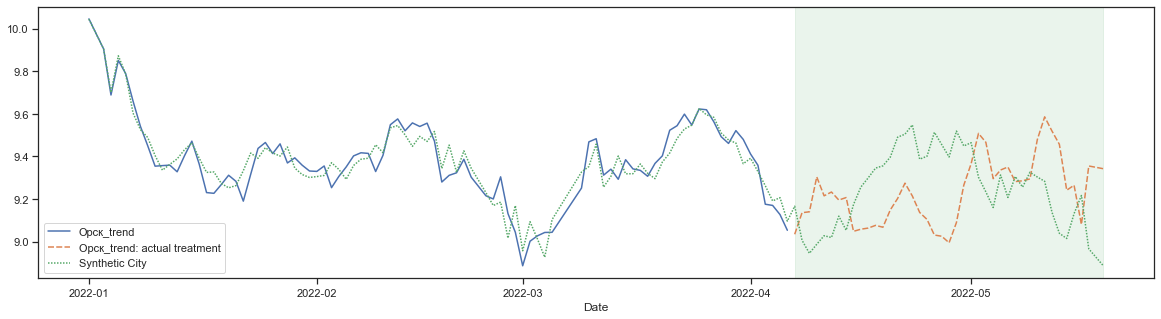

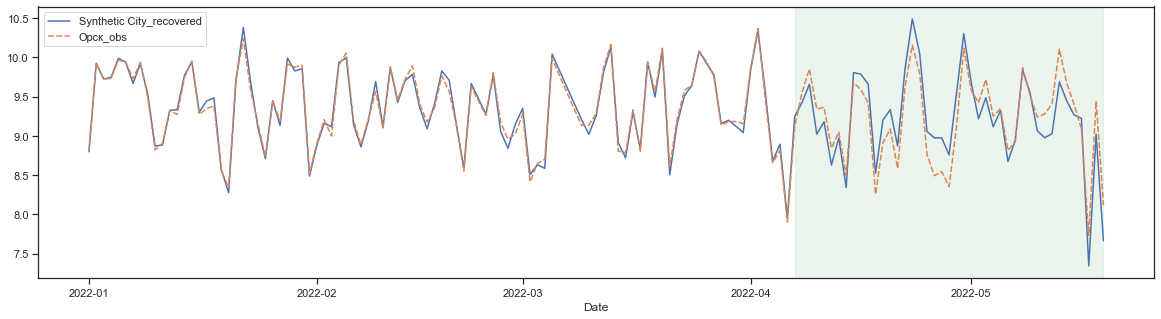

In [39]:
test_cities = ["Пенза", "Уфа", "Курск", "Нижний Тагил", "Новокуйбышевск", "Орск"]

# Заодно создаем и контрольные города
a = test_cities+["Вышний Волочек", "Копейск", "Лабытнанги", "Прокопьевск"]
controle_cities = [city for city in d.CityName.unique() if city not in a]

test_cities_tr = [city + "_trend" for city in test_cities]
controle_cities_tr = [city + "_trend" for city in controle_cities]

# Датасет с данными до теста с тестовыми городами
d_pre_treatment_test = d_pre_treatment[test_cities_tr]

# Датасет с данными до теста с контрольными городами
d_pre_treatment_control = d_pre_treatment[controle_cities_tr]

# Датасет с данными во время проведения теста с тестовыми городами
d_treatment_test  = d_treatment[test_cities_tr]

# Датасет с данными во время проведения теста с контрольными городами
d_treatment_control = d_treatment[controle_cities_tr]

city_name = test_cities_tr[5]
y = d_pre_treatment_test[city_name]
X = d_pre_treatment_control

# Выбираю топ 30 городов которые коррелируют с выбранным сильнее всего
top_N = 30

selected_cities = {}
for col in X.columns:
    selected_cities[col] = np.corrcoef(y, X[col])[0][1]

selected_cities = [k for k,v in Counter(selected_cities).most_common(top_N)]

# Настраиваем веса синтетического города с помощью линейной регрессии
regr = LinearRegression().fit(X[selected_cities], y)

# Создаем синтетический город
synthetic_city  = regr.predict(X[selected_cities])

# Заполняем пропуски
d_treatment_control = fill_nulls(d_treatment_control[selected_cities])

# Предстказанный синтетический город
city_predicted  = regr.predict(d_treatment_control[selected_cities])

city_treatment = d_treatment_test[city_name].reset_index()
city_treatment.columns = ['Date', city_name + ': actual treatment']

# Датасет для визуализации
df_comb = y.reset_index().append(city_treatment).reset_index(drop=True)
df_comb['Synthetic City'] = list(synthetic_city) + list(city_predicted)
df_comb.columns = ['Date', city_name, city_name+': actual treatment', 'Synthetic City']
df_comb.Date = pd.to_datetime(df_comb.Date, utc=True)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb.set_index('Date'))
ax.axvspan(list(df_comb.Date)[-43], list(df_comb.Date)[-1], color='g', alpha = 0.12)

#city_name = test_cities[0] 
city_name = city_name[:-6]
tmp = d_pvt[[f"{city_name}_seas", f"{city_name}_trend", f"{city_name}_res", f"{city_name}_obs"]]

# Восстановим исходные ряды:
df_comb = pd.merge(df_comb, tmp, how = "left", left_on = "Date", right_on = tmp.index)
df_comb["Synthetic City_recovered"] = df_comb["Synthetic City"] + df_comb[f"{city_name}_seas"] + df_comb[f"{city_name}_res"]
df_comb_rec = df_comb[['Date', 'Synthetic City_recovered', f'{city_name}_obs']]

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = df_comb_rec.set_index('Date'))
ax.axvspan(list(df_comb_rec.Date)[-43], list(df_comb_rec.Date)[-1], color='g', alpha = 0.12) 

test_df = df_comb_rec[df_comb_rec.Date >= "2022-04-07"]

n = len(test_df)

#### H0 средние равны (в синтетическом городе и в обозримом городе из тестовой выборки)

#### H1 средние не равны

test_df.head()

m2 = test_df["Synthetic City_recovered"].mean()
s2 = test_df["Synthetic City_recovered"].std()

m1 = test_df[f"{city_name}_obs"].mean()
s1 = test_df[f"{city_name}_obs"].std()
df = n + n - 2

w[city_name] = m1
m_test[city_name] = m1
m_control[city_name] = m2
std_test[city_name] = s1
std_control[city_name] = s2
eff[city_name] = m1 - m2

t_st = (m1 - m2)/ np.sqrt(s1**2/n + s2**2/n)
t_st

# get two-tailed p value
p_two = 2*stats.t.sf(abs(t_st), df=df)
print("p-value for two tailed:",p_two)

# get one-tailed p value
p_one = stats.t.sf(abs(t_st), df=df)
print("p-value for one tailed:",p_one)

effect = (m1 - m2)
relative_effect = np.exp(effect)

print()
print(f"Effect for log_rto: {effect:.2f}")
print(f"Relative effect for rto: {relative_effect:.2f}. Выручка в экспереминтальном городе на {(1 - relative_effect)*100:.2f} % выше.")

print()
print("Результаты теста не значимы")

## Средневзвешенный эффект (общий)

In [40]:
W = np.sum([w[i] for i in w.keys()])

In [41]:
# Эффекты для каждого города
eff

{'Пенза': 0.06444698449048403,
 'Уфа': 0.141436182108567,
 'Курск': 0.11197926582966744,
 'Нижний Тагил': 0.158119346638939,
 'Новокуйбышевск': -0.09292434543139727,
 'Орск': -0.003882743975998082}

In [42]:
# Веса каждого Города по объему выручки
w1 = {i: w[i]/W for i in w.keys()}
w1

{'Пенза': 0.17755149430609277,
 'Уфа': 0.18745672163853194,
 'Курск': 0.16485746968635828,
 'Нижний Тагил': 0.16646887737979393,
 'Новокуйбышевск': 0.15505051971225906,
 'Орск': 0.14861491727696402}

In [43]:
# Ср. эффект
avg_eff = sum([w1[i] * eff[i] for i in w.keys()])
avg_eff

0.0677533882401149

In [44]:
np.exp(avg_eff) # относительные эффект не в логарифмах (примерно на 7 % выше, но не значимо)

1.0701013763520513

In [45]:
nom = sum([w1[i] * eff[i] for i in w.keys()])
denom = np.sqrt(sum([w1[i]**2 * (std_test[i]) for i in w.keys()]))

t = nom/denom
stats.t.sf(abs(t), df = df)

0.3935980372825241

## Общий эффект у меня получился статистически не значимым

p val для одностороннего теста очень большое, что не дает нам отвергнуть нулевую гипотезу о том что эффект равен нулю

Это может быть вызвано тем что в некотрых (статистически значимых) городах иные факторы влияли на увеличение выручки по Пицце. Это может быть географически специфические факторы которые обеспечивают эффект от изменения порядка пицц на веб сайте.

Что мы можем сказать из полученных результатов, что для ряда городов эксперимент повлиял на выручку, однако мы не можем быть уверены что если мы изменим эту фичу повсеместно, то получим прирост выручки, потому что средневзвешенный эффект получился статитстически не значимым.

### Какие еще можно было тесты провести:

Когда я подбирала Синтетический контрольный город, я думала также о том что можно было бы использовать Propencity Score Matching чтобы найти города с похожими для сравнения характеритсиками.

Также можно было провести обычное сравние средних в среднем тестовом сете и в среднем контрольном, предварительно переведя в логарифмы выручку.

Можно было использовать diff in diff дизайн для оценки эффекта.

## Какие еще метрики можно было бы оценить?

Из тех что я увидела, мне пришла в голову оценить не выручку, а прибыль вычтя издержки.

Конверсию например можно было бы оценить, сколько из тех кто зашел совершил покупку.

Еще проверить бы общую выручку (есть странные интуитивные предположения, но если уж по пиццам не изменилась, то вряд-ли повлияет на общую)





# 3

Одна грустная вещь: у меня не было возможности толком потестить запрос, я нашла онлайн компайлер но он ужасно умирал и не позволял больше 500 строчек протестить, без процесса отладки в общем

## SQL SERVER
### С использованием подзапроса

Для случая если у нас каких-то дат не хватат в базе это будет отрабатывать некорректно,
с другой стороны если каких-то дат в базе нет сам процесс вычисления станет не очень корректным, так что для этого случая считаем базу по существующим дням только получается.
Чтобы учесть "Пропущенные даты" этот запрос можно создав таблицу со всеми датами и присоединив к ней справа таблицу с каунтами.

In [46]:
"""

SELECT  

    cityname,
    date,
    sum(daily_cnt) over (order by date ROWS BETWEEN 30 PRECEDING AND CURRENT ROW) as active_base

FROM (SELECT
        cityname,
        date,
        count(distinct clientid) as daily_cnt
     FROM task
     GROUP BY cityname, date) as distinct_client  

ORDER BY cityname, date

"""


'\n\nSELECT  \n\n    cityname,\n    date,\n    sum(daily_cnt) over (order by date ROWS BETWEEN 30 PRECEDING AND CURRENT ROW) as active_base\n\nFROM (SELECT\n        cityname,\n        date,\n        count(distinct clientid) as daily_cnt\n     FROM task\n     GROUP BY cityname, date) as distinct_client  \n\nORDER BY cityname, date\n\n'

## SQL SERVER
### С использованием предcтавлений

In [47]:
"""
WITH distinct_client AS (

    SELECT
    
         cityname,
         date,
         count(distinct clientid) as daily_cnt

     FROM task

     GROUP BY cityname, date

)


SELECT  

    cityname,
    date,
    sum(daily_cnt) over (order by date ROWS BETWEEN 30 PRECEDING AND CURRENT ROW) as active_base

FROM distinct_client  

ORDER BY cityname, date

"""


'\nWITH distinct_client AS (\n\n    SELECT\n    \n         cityname,\n         date,\n         count(distinct clientid) as daily_cnt\n\n     FROM task\n\n     GROUP BY cityname, date\n\n)\n\n\nSELECT  \n\n    cityname,\n    date,\n    sum(daily_cnt) over (order by date ROWS BETWEEN 30 PRECEDING AND CURRENT ROW) as active_base\n\nFROM distinct_client  \n\nORDER BY cityname, date\n\n'